In [169]:
import ast
import random
import json
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
import dateutil
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2, ttest_ind_from_stats, mannwhitneyu, wilcoxon


In [2]:
animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

qval_sampling = data['fdr corrected pval effect of sampling']
# qval_sampling.replace(np.nan, 1, inplace=True)  # For replacing blanks (model failed to converge) with 1
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

array([[<AxesSubplot:title={'center':'l_496'}>]], dtype=object)

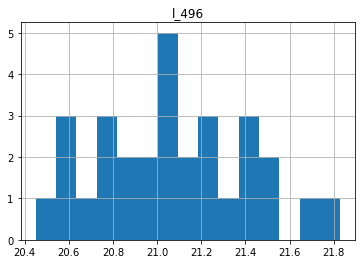

In [37]:
data[fbg_cols].sample(1).T.hist(bins=15)

array([[<AxesSubplot:title={'center':'l_623'}>]], dtype=object)

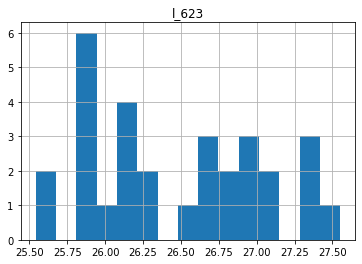

In [50]:
data[rbg_cols].sample(1).T.hist(bins=15)

## Mann-Whitney U test is non-parametric, but it only works for independent samples and where the number of observations in each sample is > 20 

# Therefore, use Wilcoxon signed rank

# NOTE: When you do (random - fasted) and alternative='greater', then p-val < 0.05 means that the random variance is greater than fasted variance, which is bad for Huishi's method!

## You should use p-value < 0.025 because we're doing a one-sided test.
### We don't care if variance is less 

In [194]:
(rn-fn).join((ri-fi)).join((rd-fd))

,1091_10,1091_8,1091_9,1093_10,1093_8,1093_9,1060_10,1060_8,1060_9,1062_10,...,1102_9,1076_10,1076_8,1076_9,1082_10,1082_8,1082_9,1101_10,1101_8,1101_9
i,,,,,,,,,,,,,,,,,,,,,
l_0,-0.708310,0.884233,0.711846,0.770027,-0.977208,0.995914,-0.425163,0.762468,0.835975,0.476012,...,-0.286461,3.722562,-0.004123,-0.552920,0.013987,0.056538,0.085746,1.590183,-0.117669,-0.354883
l_1,-1.369399,0.515015,2.314242,0.119779,-1.024660,0.758051,0.269577,0.423435,-0.023832,0.662165,...,-0.182904,3.303506,0.759920,-1.710969,-0.163422,-1.136440,-0.008902,0.780862,-0.095000,-0.414530
l_2,-2.272524,0.972198,0.097458,-0.053211,0.571366,1.202672,0.733722,1.165740,-0.988012,0.978415,...,-0.069807,3.801993,0.526637,-0.289290,0.218890,-1.549619,0.334087,0.346933,0.134471,-0.511450
l_3,0.004855,0.178739,0.724140,0.268382,-0.569851,0.641241,0.329586,-0.736501,0.375151,0.326306,...,0.325276,3.034973,0.387636,-0.900835,0.324078,-0.459425,0.068995,1.310297,0.167055,0.009474
l_4,-0.949849,0.032159,1.974094,0.050111,-0.924058,1.574107,0.381790,0.808112,-0.991239,0.778939,...,-0.129506,4.068257,1.104012,0.268086,0.372613,-0.424465,1.249259,0.213791,-0.241422,0.063558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m_169,0.094222,0.054788,-0.032673,-0.064008,0.466792,-0.296321,0.169676,-0.334511,0.303470,-0.135319,...,-0.073327,-0.286843,-0.206114,0.376110,0.244695,0.081736,0.175729,-0.227537,0.383401,0.144526
m_213,4.061983,4.517623,-2.196746,1.230353,0.198125,3.767560,4.447641,6.354876,-2.481861,6.455582,...,3.679821,1.910557,-1.346682,4.800427,-2.158658,2.337183,3.781206,-2.343802,5.713352,4.038487
m_24,0.809958,0.678004,-0.678367,0.584694,0.030550,0.885453,1.267490,1.623244,-0.598435,1.848786,...,0.928558,0.672493,-0.091483,1.586770,-0.375597,0.650125,1.044332,-0.469011,1.401047,0.668590


In [222]:
wr = defaultdict(lambda: {})
all_paired = (rn - fn).join((ri - fi)).join((rd - fd))
for bg_type, df in [('n', rn - fn), ('i', ri - fi), ('d', rd - fd), ('all', all_paired)]:
    for i, row in df.iterrows():
        w = wilcoxon(row, alternative='greater')
        wr[i][bg_type+'_r_greater_var'] = w[1]
        w = wilcoxon(row, alternative='less')
#         print(row)
#         print(row * -1)
        wr[i][bg_type+'_f_greater_var'] = w[1]
w = pd.DataFrame(wr).T
for col in ['n_r_greater_var', 'i_r_greater_var', 'd_r_greater_var', 'all_r_greater_var', 
            'n_f_greater_var', 'i_f_greater_var', 'd_f_greater_var', 'all_f_greater_var']:
    w[col + 'fdr'] = fdrcorrection(w[col])[1]
w = w.filter(regex='fdr')

In [226]:
w.sample(30)

,n_r_greater_varfdr,i_r_greater_varfdr,d_r_greater_varfdr,all_r_greater_varfdr,n_f_greater_varfdr,i_f_greater_varfdr,d_f_greater_varfdr,all_f_greater_varfdr
m_701,1.000000,0.493427,0.122746,0.055966,0.996429,1.000000,1.000000,0.999999
l_536,0.281087,0.000473,0.009979,0.000016,1.000000,1.000000,1.000000,0.999999
l_537,1.000000,0.327935,0.719707,0.634334,0.742999,1.000000,1.000000,0.999999
m_331,0.708783,0.823557,0.766874,0.622000,1.000000,1.000000,1.000000,0.999999
l_70,1.000000,0.182652,0.190927,0.109720,0.924518,1.000000,1.000000,0.999999
l_692,1.000000,1.000000,0.226906,0.999999,0.083285,0.002784,1.000000,0.009255
m_584,1.000000,1.000000,1.000000,0.999999,0.083285,0.000329,0.082269,0.000027
m_451,1.000000,1.000000,0.190927,0.716276,0.742999,0.950980,1.000000,0.999999
l_33,0.708783,1.000000,1.000000,0.999999,1.000000,0.669411,0.717471,0.441207
l_187,1.000000,1.000000,0.368114,0.999999,0.443822,0.849449,1.000000,0.696958


<AxesSubplot:>

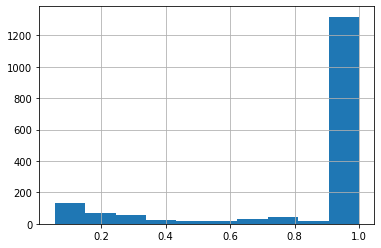

In [232]:
w['d_f_greater_varfdr'].hist()

In [230]:
for col in ['n_f_greater_varfdr', 'i_f_greater_varfdr', 'd_f_greater_varfdr', 'all_f_greater_varfdr']:
    print(col, w.loc[w[col] < 0.025].shape[0])

n_f_greater_varfdr 0
i_f_greater_varfdr 321
d_f_greater_varfdr 0
all_f_greater_varfdr 352


In [227]:
for col in ['n_r_greater_varfdr', 'i_r_greater_varfdr', 'd_r_greater_varfdr', 'all_r_greater_varfdr']:
    print(col, w.loc[w[col] < 0.025].shape[0])

n_r_greater_varfdr 0
i_r_greater_varfdr 481
d_r_greater_varfdr 461
all_r_greater_varfdr 591


In [198]:
w.loc[(w[['nfdr', 'ifdr', ]] < 0.05).any(axis=1), ['ifdr', 'dfdr']]

,ifdr,dfdr
l_59,0.035847,0.156116
l_62,0.000902,0.044466
l_63,0.000399,0.009979
l_64,0.000399,0.009979
l_67,0.041824,0.096810
...,...,...
m_340,0.012686,0.056785
m_616,0.002011,0.009979
m_557,0.000473,0.009979
m_213,0.012686,0.156116


In [206]:
ifdr = set(w.loc[w['ifdr'] < 0.025].index)
dfdr = set(w.loc[w['dfdr'] < 0.025].index)
idfdr = set(w.loc[(w[['ifdr', 'dfdr']] < 0.025).any(axis=1)].index)

In [212]:
print('number of metabolites found in only one significance list')
print(len(ifdr.symmetric_difference(dfdr)))
print(len(idfdr.symmetric_difference(dfdr)))
print(len(idfdr.symmetric_difference(ifdr)))


number of metabolites found in only one significance list
150
85
65


<AxesSubplot:>

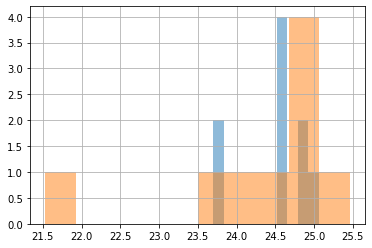

In [184]:
rd.loc['l_1'].hist(alpha=0.5)
fd.loc['l_1'].hist(alpha=0.5)

In [179]:
random = np.array([10, 11, 12, 13, 12, ])  # Random
fasted = np.array([5,  4,  3,  3,  3,  ])  # Fasted

w, p = wilcoxon(random - fasted, alternative='greater')
w, p
# Here, random is clearly bigger, so it has a significant p-value

(15.0, 0.03125)

In [90]:
tt = {}
for (i, rowf), (j, rowr) in zip(fn.iterrows(), rn.iterrows()):
    t = mannwhitneyu(rowf, rowr, alternative='two-sided')
#     print(t)
    tt[i] = {'n': t.pvalue}

for (i, rowf), (j, rowr) in zip(fi.iterrows(), ri.iterrows()):
    t = mannwhitneyu(rowf, rowr, alternative='two-sided')
#     print(t)
    tt[i]['i'] = t.pvalue

for (i, rowf), (j, rowr) in zip(fd.iterrows(), rd.iterrows()):
    t = mannwhitneyu(rowf, rowr, alternative='two-sided')
#     print(t)
    tt[i]['d'] = t.pvalue


MannwhitneyuResult(statistic=56.0, pvalue=0.020191414969204246)
MannwhitneyuResult(statistic=105.0, pvalue=0.7715511878155722)
MannwhitneyuResult(statistic=83.0, pvalue=0.22902896662469463)
MannwhitneyuResult(statistic=79.0, pvalue=0.17106923105635186)
MannwhitneyuResult(statistic=90.0, pvalue=0.3614963660708982)
MannwhitneyuResult(statistic=115.0, pvalue=0.9338864180775845)
MannwhitneyuResult(statistic=122.0, pvalue=0.7089232340537643)
MannwhitneyuResult(statistic=114.0, pvalue=0.9669147771731937)
MannwhitneyuResult(statistic=117.0, pvalue=0.8682259903524354)
MannwhitneyuResult(statistic=125.0, pvalue=0.6186695570822622)
MannwhitneyuResult(statistic=109.0, pvalue=0.9009714934164412)
MannwhitneyuResult(statistic=94.0, pvalue=0.4553018964198552)
MannwhitneyuResult(statistic=153.0, pvalue=0.09709106759647709)
MannwhitneyuResult(statistic=134.0, pvalue=0.38373262766250305)
MannwhitneyuResult(statistic=96.0, pvalue=0.506914933812496)
MannwhitneyuResult(statistic=76.0, pvalue=0.135382110045

MannwhitneyuResult(statistic=0.0, pvalue=3.3918213908250945e-06)
MannwhitneyuResult(statistic=145.0, pvalue=0.1844100692216365)
MannwhitneyuResult(statistic=0.0, pvalue=3.3918213908250945e-06)
MannwhitneyuResult(statistic=56.0, pvalue=0.020191414969204246)
MannwhitneyuResult(statistic=54.0, pvalue=0.01614027989360373)
MannwhitneyuResult(statistic=5.0, pvalue=9.073400856319234e-06)
MannwhitneyuResult(statistic=0.0, pvalue=3.3918213908250945e-06)
MannwhitneyuResult(statistic=112.0, pvalue=1.0)
MannwhitneyuResult(statistic=177.0, pvalue=0.00794033626424658)
MannwhitneyuResult(statistic=76.0, pvalue=0.13538211004560674)
MannwhitneyuResult(statistic=17.0, pvalue=8.13402807598356e-05)
MannwhitneyuResult(statistic=72.0, pvalue=0.09709106759647709)
MannwhitneyuResult(statistic=7.0, pvalue=1.3294722762606463e-05)
MannwhitneyuResult(statistic=3.0, pvalue=6.151638741096579e-06)
MannwhitneyuResult(statistic=73.0, pvalue=0.10573920209087935)
MannwhitneyuResult(statistic=1.0, pvalue=4.14322009753753

MannwhitneyuResult(statistic=6.0, pvalue=1.0992164801504738e-05)
MannwhitneyuResult(statistic=1.0, pvalue=4.143220097537536e-06)
MannwhitneyuResult(statistic=19.0, pvalue=0.00011457127866286101)
MannwhitneyuResult(statistic=182.0, pvalue=0.004209946028667896)
MannwhitneyuResult(statistic=11.0, pvalue=2.7983495853192978e-05)
MannwhitneyuResult(statistic=31.0, pvalue=0.0007802051762911044)
MannwhitneyuResult(statistic=12.0, pvalue=3.356755084154065e-05)
MannwhitneyuResult(statistic=19.0, pvalue=0.00011457127866286101)
MannwhitneyuResult(statistic=70.0, pvalue=0.08149464839345506)
MannwhitneyuResult(statistic=9.0, pvalue=1.9351827710442478e-05)
MannwhitneyuResult(statistic=66.0, pvalue=0.05639236422683157)
MannwhitneyuResult(statistic=135.0, pvalue=0.3614963660708982)
MannwhitneyuResult(statistic=78.0, pvalue=0.15846460599820356)
MannwhitneyuResult(statistic=6.0, pvalue=1.0992164801504738e-05)
MannwhitneyuResult(statistic=117.0, pvalue=0.8682259903524354)
MannwhitneyuResult(statistic=152.

MannwhitneyuResult(statistic=222.0, pvalue=6.151638741096579e-06)
MannwhitneyuResult(statistic=115.0, pvalue=0.9338864180775845)
MannwhitneyuResult(statistic=123.0, pvalue=0.6783024655972324)
MannwhitneyuResult(statistic=40.0, pvalue=0.0028226386759533724)
MannwhitneyuResult(statistic=186.0, pvalue=0.0024626042007544527)
MannwhitneyuResult(statistic=211.0, pvalue=4.8063230506309336e-05)
MannwhitneyuResult(statistic=217.0, pvalue=1.6053092802023668e-05)
MannwhitneyuResult(statistic=213.0, pvalue=3.356755084154065e-05)
MannwhitneyuResult(statistic=208.0, pvalue=8.13402807598356e-05)
MannwhitneyuResult(statistic=208.0, pvalue=8.13402807598356e-05)
MannwhitneyuResult(statistic=211.0, pvalue=4.8063230506309336e-05)
MannwhitneyuResult(statistic=208.0, pvalue=8.13402807598356e-05)
MannwhitneyuResult(statistic=51.0, pvalue=0.01140098291155517)
MannwhitneyuResult(statistic=94.0, pvalue=0.4553018964198552)
MannwhitneyuResult(statistic=169.0, pvalue=0.020191414969204246)
MannwhitneyuResult(statis

MannwhitneyuResult(statistic=122.0, pvalue=0.7089232340537643)
MannwhitneyuResult(statistic=124.0, pvalue=0.6482039260122094)
MannwhitneyuResult(statistic=123.0, pvalue=0.6783024655972324)
MannwhitneyuResult(statistic=109.0, pvalue=0.9009714934164412)
MannwhitneyuResult(statistic=145.0, pvalue=0.1844100692216365)
MannwhitneyuResult(statistic=148.0, pvalue=0.14657603430900068)
MannwhitneyuResult(statistic=121.0, pvalue=0.7400217511938185)
MannwhitneyuResult(statistic=134.0, pvalue=0.38373262766250305)
MannwhitneyuResult(statistic=112.0, pvalue=1.0)
MannwhitneyuResult(statistic=122.0, pvalue=0.7089232340537643)
MannwhitneyuResult(statistic=86.0, pvalue=0.28084201086629845)
MannwhitneyuResult(statistic=211.0, pvalue=4.8063230506309336e-05)
MannwhitneyuResult(statistic=103.0, pvalue=0.7089232340537643)
MannwhitneyuResult(statistic=122.0, pvalue=0.7089232340537643)
MannwhitneyuResult(statistic=79.0, pvalue=0.17106923105635186)
MannwhitneyuResult(statistic=54.0, pvalue=0.01614027989360373)
M

MannwhitneyuResult(statistic=24.0, pvalue=0.00026216888813650863)
MannwhitneyuResult(statistic=36.0, pvalue=0.001619713575230349)
MannwhitneyuResult(statistic=15.0, pvalue=5.737063008488556e-05)
MannwhitneyuResult(statistic=34.0, pvalue=0.0012151954178690621)
MannwhitneyuResult(statistic=22.0, pvalue=0.00018919298065443355)
MannwhitneyuResult(statistic=26.0, pvalue=0.0003609347195741741)
MannwhitneyuResult(statistic=23.0, pvalue=0.0002228932910846752)
MannwhitneyuResult(statistic=24.0, pvalue=0.00026216888813650863)
MannwhitneyuResult(statistic=18.0, pvalue=9.661535870152319e-05)
MannwhitneyuResult(statistic=28.0, pvalue=0.0004936885181146133)
MannwhitneyuResult(statistic=41.0, pvalue=0.0032301435955866646)
MannwhitneyuResult(statistic=48.0, pvalue=0.00794033626424658)
MannwhitneyuResult(statistic=73.0, pvalue=0.10573920209087935)
MannwhitneyuResult(statistic=39.0, pvalue=0.0024626042007544527)
MannwhitneyuResult(statistic=77.0, pvalue=0.14657603430900068)
MannwhitneyuResult(statistic=

MannwhitneyuResult(statistic=128.0, pvalue=0.5338294217441396)
MannwhitneyuResult(statistic=112.0, pvalue=1.0)
MannwhitneyuResult(statistic=136.0, pvalue=0.3400858902842717)
MannwhitneyuResult(statistic=89.0, pvalue=0.3400858902842717)
MannwhitneyuResult(statistic=129.0, pvalue=0.506914933812496)
MannwhitneyuResult(statistic=124.0, pvalue=0.6482039260122094)
MannwhitneyuResult(statistic=117.0, pvalue=0.8682259903524354)
MannwhitneyuResult(statistic=124.0, pvalue=0.6482039260122094)
MannwhitneyuResult(statistic=126.0, pvalue=0.5897385933186072)
MannwhitneyuResult(statistic=132.0, pvalue=0.43064798984807773)
MannwhitneyuResult(statistic=132.0, pvalue=0.43064798984807773)
MannwhitneyuResult(statistic=137.0, pvalue=0.3195059648919748)
MannwhitneyuResult(statistic=88.0, pvalue=0.3195059648919748)
MannwhitneyuResult(statistic=85.0, pvalue=0.26275304114766074)
MannwhitneyuResult(statistic=126.0, pvalue=0.5897385933186072)
MannwhitneyuResult(statistic=131.0, pvalue=0.4553018964198552)
Mannwhit

MannwhitneyuResult(statistic=85.0, pvalue=0.26275304114766074)
MannwhitneyuResult(statistic=83.0, pvalue=0.22902896662469463)
MannwhitneyuResult(statistic=53.0, pvalue=0.014396852751179462)
MannwhitneyuResult(statistic=56.0, pvalue=0.020191414969204246)
MannwhitneyuResult(statistic=37.0, pvalue=0.0018654646290708888)
MannwhitneyuResult(statistic=118.0, pvalue=0.8357050269952793)
MannwhitneyuResult(statistic=29.0, pvalue=0.0005759812107616887)
MannwhitneyuResult(statistic=31.0, pvalue=0.0007802051762911044)
MannwhitneyuResult(statistic=47.0, pvalue=0.007016199234239618)
MannwhitneyuResult(statistic=44.0, pvalue=0.004794758682161994)
MannwhitneyuResult(statistic=56.0, pvalue=0.020191414969204246)
MannwhitneyuResult(statistic=50.0, pvalue=0.010121802247772722)
MannwhitneyuResult(statistic=136.0, pvalue=0.3400858902842717)
MannwhitneyuResult(statistic=5.0, pvalue=9.073400856319234e-06)
MannwhitneyuResult(statistic=9.0, pvalue=1.9351827710442478e-05)
MannwhitneyuResult(statistic=27.0, pvalu

MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=1.0, pvalue=0.0005736335109885613)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=1.0, pvalue=0.0005736335109885613)
MannwhitneyuResult(statistic=1.0, pvalue=0.0005736335109885613)
MannwhitneyuResult(statistic=48.0, pvalue=0.5364994693194564)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=3.0, pvalue=0.0010862466258220339)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=66.0, pvalue=0.0272753837615853)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=45.0, pvalue=0.7239320396139757)
MannwhitneyuResult(statistic=0.0, pval

MannwhitneyuResult(statistic=2.0, pvalue=0.0007922682038502908)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=5.0, pvalue=0.0019976900972723025)
MannwhitneyuResult(statistic=43.0, pvalue=0.859819205054158)
MannwhitneyuResult(statistic=22.0, pvalue=0.11196135426374831)
MannwhitneyuResult(statistic=81.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=64.0, pvalue=0.04226010608395664)
MannwhitneyuResult(statistic=38.0, pvalue=0.859819205054158)
MannwhitneyuResult(statistic=14.0, pvalue=0.021684111364991994)
MannwhitneyuResult(statistic=76.0, pvalue=0.0019976900972723025)
MannwhitneyuResult(statistic=71.0, pvalue=0.008071487425268009)
MannwhitneyuResult(statistic=67.0, pvalue=0.021684111364991994)
MannwhitneyuResult(statistic=62.0, pvalue=0.06368977513662868)
MannwhitneyuResult(statistic=12.0, pvalue=0.013418657920497472)
MannwhitneyuResult(statistic=14.0, pvalue=0.021684111364991994)
MannwhitneyuResult(statistic=10.0, pvalue=0.0

MannwhitneyuResult(statistic=5.0, pvalue=0.0019976900972723025)
MannwhitneyuResult(statistic=23.0, pvalue=0.1333202155896274)
MannwhitneyuResult(statistic=12.0, pvalue=0.013418657920497472)
MannwhitneyuResult(statistic=62.0, pvalue=0.06368977513662868)
MannwhitneyuResult(statistic=25.0, pvalue=0.18532630419857943)
MannwhitneyuResult(statistic=31.0, pvalue=0.42677673653298365)
MannwhitneyuResult(statistic=60.0, pvalue=0.0933976745287926)
MannwhitneyuResult(statistic=22.0, pvalue=0.11196135426374831)
MannwhitneyuResult(statistic=81.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=74.0, pvalue=0.003568628436933387)
MannwhitneyuResult(statistic=70.0, pvalue=0.010444271101370226)
MannwhitneyuResult(statistic=56.0, pvalue=0.18532630419857943)
MannwhitneyuResult(statistic=74.0, pvalue=0.003568628436933387)
MannwhitneyuResult(statistic=47.0, pvalue=0.5962416305866567)
MannwhitneyuResult(statistic=41.0, pvalue=1.0)
MannwhitneyuResult(statistic=43.0, pvalue=0.859819205054158)
Mannw

MannwhitneyuResult(statistic=41.0, pvalue=1.0)
MannwhitneyuResult(statistic=58.0, pvalue=0.1333202155896274)
MannwhitneyuResult(statistic=43.0, pvalue=0.859819205054158)
MannwhitneyuResult(statistic=42.0, pvalue=0.9296365245070707)
MannwhitneyuResult(statistic=46.0, pvalue=0.6588432549492806)
MannwhitneyuResult(statistic=32.0, pvalue=0.47992869214595724)
MannwhitneyuResult(statistic=12.0, pvalue=0.013418657920497472)
MannwhitneyuResult(statistic=13.0, pvalue=0.01711823970479015)
MannwhitneyuResult(statistic=3.0, pvalue=0.0010862466258220339)
MannwhitneyuResult(statistic=13.0, pvalue=0.01711823970479015)
MannwhitneyuResult(statistic=15.0, pvalue=0.0272753837615853)
MannwhitneyuResult(statistic=11.0, pvalue=0.010444271101370226)
MannwhitneyuResult(statistic=26.0, pvalue=0.21637300805763748)
MannwhitneyuResult(statistic=11.0, pvalue=0.010444271101370226)
MannwhitneyuResult(statistic=13.0, pvalue=0.01711823970479015)
MannwhitneyuResult(statistic=19.0, pvalue=0.06368977513662868)
Mannwhitne

MannwhitneyuResult(statistic=38.0, pvalue=0.859819205054158)
MannwhitneyuResult(statistic=42.0, pvalue=0.9296365245070707)
MannwhitneyuResult(statistic=44.0, pvalue=0.7910815129207817)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=42.0, pvalue=0.9296365245070707)
MannwhitneyuResult(statistic=40.0, pvalue=1.0)
MannwhitneyuResult(statistic=38.0, pvalue=0.859819205054158)
MannwhitneyuResult(statistic=31.0, pvalue=0.42677673653298365)
MannwhitneyuResult(statistic=25.0, pvalue=0.18532630419857943)
MannwhitneyuResult(statistic=29.0, pvalue=0.331387096247615)
MannwhitneyuResult(statistic=29.0, pvalue=0.331387096247615)
MannwhitneyuResult(statistic=7.0, pvalue=0.003568628436933387)
MannwhitneyuResult(statistic=11.0, pvalue=0.010444271101370226)
MannwhitneyuResult(statistic=8.0, pvalue=0.004718198728115028)
MannwhitneyuResult(statistic=52.0, pvalue=0.331387096247615)
MannwhitneyuResult(statistic=43.0, pvalue=0.859819205054158)
MannwhitneyuResult(s

MannwhitneyuResult(statistic=30.0, pvalue=0.37722461666745344)
MannwhitneyuResult(statistic=57.0, pvalue=0.1577043874630777)
MannwhitneyuResult(statistic=53.0, pvalue=0.28931483238198774)
MannwhitneyuResult(statistic=55.0, pvalue=0.21637300805763748)
MannwhitneyuResult(statistic=63.0, pvalue=0.052058768750600205)
MannwhitneyuResult(statistic=46.0, pvalue=0.6588432549492806)
MannwhitneyuResult(statistic=66.0, pvalue=0.0272753837615853)
MannwhitneyuResult(statistic=63.0, pvalue=0.052058768750600205)
MannwhitneyuResult(statistic=68.0, pvalue=0.01711823970479015)
MannwhitneyuResult(statistic=67.0, pvalue=0.021684111364991994)
MannwhitneyuResult(statistic=68.0, pvalue=0.01711823970479015)
MannwhitneyuResult(statistic=64.0, pvalue=0.04226010608395664)
MannwhitneyuResult(statistic=64.0, pvalue=0.04226010608395664)
MannwhitneyuResult(statistic=66.0, pvalue=0.0272753837615853)
MannwhitneyuResult(statistic=66.0, pvalue=0.0272753837615853)
MannwhitneyuResult(statistic=68.0, pvalue=0.0171182397047

MannwhitneyuResult(statistic=42.0, pvalue=0.9296365245070707)
MannwhitneyuResult(statistic=52.0, pvalue=0.331387096247615)
MannwhitneyuResult(statistic=12.0, pvalue=0.013418657920497472)
MannwhitneyuResult(statistic=0.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=27.0, pvalue=0.25099827044292256)
MannwhitneyuResult(statistic=27.0, pvalue=0.25099827044292256)
MannwhitneyuResult(statistic=31.0, pvalue=0.42677673653298365)
MannwhitneyuResult(statistic=37.0, pvalue=0.7910815129207817)
MannwhitneyuResult(statistic=67.0, pvalue=0.021684111364991994)
MannwhitneyuResult(statistic=81.0, pvalue=0.00041229480206169127)
MannwhitneyuResult(statistic=67.0, pvalue=0.021684111364991994)
MannwhitneyuResult(statistic=38.0, pvalue=0.859819205054158)
MannwhitneyuResult(statistic=68.0, pvalue=0.01711823970479015)
MannwhitneyuResult(statistic=1.0, pvalue=0.0005736335109885613)
MannwhitneyuResult(statistic=47.0, pvalue=0.5962416305866567)
MannwhitneyuResult(statistic=0.0, pvalue=0.0004122948

In [91]:
tt

{'l_0': {'n': 0.3784775932446789,
  'i': 0.020191414969204246,
  'd': 0.42677673653298365},
 'l_1': {'n': 0.8101812364104737,
  'i': 0.7715511878155722,
  'd': 0.5962416305866567},
 'l_2': {'n': 0.2979530616081678,
  'i': 0.22902896662469463,
  'd': 0.42677673653298365},
 'l_3': {'n': 0.06555216116550257,
  'i': 0.17106923105635186,
  'd': 0.18532630419857943},
 'l_4': {'n': 0.3784775932446789,
  'i': 0.3614963660708982,
  'd': 0.034069195144143936},
 'l_5': {'n': 0.8101812364104737,
  'i': 0.9338864180775845,
  'd': 0.859819205054158},
 'l_6': {'n': 0.4711699984900557,
  'i': 0.7089232340537643,
  'd': 0.7910815129207817},
 'l_7': {'n': 0.4711699984900557,
  'i': 0.9669147771731937,
  'd': 0.9296365245070707},
 'l_8': {'n': 0.4711699984900557,
  'i': 0.8682259903524354,
  'd': 0.859819205054158},
 'l_9': {'n': 0.5751735319201967,
  'i': 0.6186695570822622,
  'd': 0.18532630419857943},
 'l_10': {'n': 0.9361862934730594,
  'i': 0.9009714934164412,
  'd': 0.5962416305866567},
 'l_11': {'

In [87]:
for m in tt:
    for nid in tt[m]:
        print(tt[m][nid].pvalue)

0.3784775932446789
0.020191414969204246
0.42677673653298365
0.8101812364104737
0.7715511878155722
0.5962416305866567
0.2979530616081678
0.22902896662469463
0.42677673653298365
0.06555216116550257
0.17106923105635186
0.18532630419857943
0.3784775932446789
0.3614963660708982
0.034069195144143936
0.8101812364104737
0.9338864180775845
0.859819205054158
0.4711699984900557
0.7089232340537643
0.7910815129207817
0.4711699984900557
0.9669147771731937
0.9296365245070707
0.4711699984900557
0.8682259903524354
0.859819205054158
0.5751735319201967
0.6186695570822622
0.18532630419857943
0.9361862934730594
0.9009714934164412
0.5962416305866567
0.6889205558044607
0.4553018964198552
0.28931483238198774
0.2979530616081678
0.09709106759647709
0.006193318174044277
0.013065226764425961
0.38373262766250305
0.7910815129207817
0.8101812364104737
0.506914933812496
0.6588432549492806
0.8101812364104737
0.13538211004560674
0.28931483238198774
0.6889205558044607
0.14657603430900068
0.21637300805763748
0.4711699984

0.09709106759647709
0.052058768750600205
0.2979530616081678
0.01140098291155517
0.003568628436933387
0.9361862934730594
0.0001603262273507153
0.034069195144143936
0.12820527503039147
0.004794758682161994
0.006193318174044277
0.005074868097940253
0.0001603262273507153
0.0026797144168214833
0.09269580255781257
1.6053092802023668e-05
0.0010862466258220339
0.12820527503039147
1.0992164801504738e-05
0.00041229480206169127
0.12820527503039147
0.6783024655972324
0.5364994693194564
0.00823901882572464
4.143220097537536e-06
0.0005736335109885613
0.005074868097940253
0.0001603262273507153
0.7239320396139757
0.06555216116550257
4.0199730927471705e-05
0.004718198728115028
0.06555216116550257
0.0003609347195741741
0.013418657920497472
0.06555216116550257
0.00018919298065443355
0.008071487425268009
0.22976627046113807
0.0005759812107616887
0.06368977513662868
0.09269580255781257
0.0007802051762911044
0.0272753837615853
0.04532756207797214
0.00018919298065443355
0.013418657920497472
0.229766270461138

0.052058768750600205
0.5751735319201967
0.0005759812107616887
0.010444271101370226
0.3784775932446789
0.0001603262273507153
0.021684111364991994
0.5751735319201967
0.0004936885181146133
0.013418657920497472
0.4711699984900557
0.00013564226281566485
0.01711823970479015
0.09269580255781257
0.1985058531538877
0.37722461666745344
0.06555216116550257
0.14657603430900068
0.5962416305866567
0.06555216116550257
0.0744956919139866
0.28931483238198774
0.22976627046113807
0.5338294217441396
0.5962416305866567
0.1734854683214785
0.12486035998214667
0.37722461666745344
0.12820527503039147
0.03439744889250225
0.7910815129207817
0.06555216116550257
0.042110616791807005
0.331387096247615
0.3784775932446789
0.28084201086629845
0.034069195144143936
0.06555216116550257
0.506914933812496
0.7910815129207817
0.00823901882572464
0.0005759812107616887
0.9296365245070707
0.020240570577077482
0.0006709034051003711
0.9296365245070707
0.04532756207797214
0.6186695570822622
0.28931483238198774
0.12820527503039147


0.5364994693194564
0.00823901882572464
3.356755084154065e-05
0.021684111364991994
0.09269580255781257
3.356755084154065e-05
0.0005736335109885613
0.06555216116550257
0.042110616791807005
0.010444271101370226
0.005074868097940253
9.073400856319234e-06
0.013418657920497472
0.005074868097940253
1.6053092802023668e-05
0.008071487425268009
0.06555216116550257
0.0007802051762911044
0.003568628436933387
0.6889205558044607
0.38373262766250305
0.7239320396139757
0.06555216116550257
0.0002228932910846752
0.0007922682038502908
0.04532756207797214
3.356755084154065e-05
0.0014784647972275091
0.12820527503039147
0.005452139856940547
0.7910815129207817
0.6889205558044607
9.661535870152319e-05
0.00041229480206169127
0.1734854683214785
0.00011457127866286101
0.0005736335109885613
0.12820527503039147
8.13402807598356e-05
0.0010862466258220339
0.2979530616081678
0.007016199234239618
0.013418657920497472
0.1734854683214785
0.00042246757669391977
0.0014784647972275091
0.09269580255781257
2.7983495853192978

0.6889205558044607
0.5614474146848649
0.859819205054158
0.2979530616081678
0.1844100692216365
0.01711823970479015
0.06555216116550257
9.661535870152319e-05
0.0005736335109885613
0.9361862934730594
0.9009714934164412
0.5962416305866567
0.030638987937703265
4.143220097537536e-06
0.00041229480206169127
0.1734854683214785
0.0002228932910846752
0.021684111364991994
0.06555216116550257
9.073400856319234e-06
0.0005736335109885613
0.06555216116550257
5.737063008488556e-05
0.006193318174044277
0.06555216116550257
4.0199730927471705e-05
0.006193318174044277
0.00823901882572464
0.00011457127866286101
0.006193318174044277
0.013065226764425961
5.737063008488556e-05
0.006193318174044277
0.22976627046113807
0.05639236422683157
0.9296365245070707
0.06555216116550257
0.02792505735330741
0.021684111364991994
0.4711699984900557
0.8682259903524354
0.06368977513662868
0.04532756207797214
0.5338294217441396
0.21637300805763748
0.1734854683214785
0.8357050269952793
0.21637300805763748
0.06555216116550257
0.4

In [118]:
fdrcorrection(mwr['n'])[1]

array([0.55205304, 0.8833226 , 0.47644902, ..., 0.22967812, 0.40449169,
       0.22967812])

In [119]:
mwr = pd.DataFrame(tt).T  # Mann-Whitney Result
mwr['n_fdr'] = fdrcorrection(mwr['n'])[1]
mwr['i_fdr'] = fdrcorrection(mwr['i'])[1]
mwr['d_fdr'] = fdrcorrection(mwr['d'])[1]

In [126]:
mwr.loc[(mwr[['i_fdr', 'd_fdr']] < 0.05).all(axis=1)]

,n,i,d,n_fdr,i_fdr,d_fdr
l_51,0.005075,0.000223,0.002680,0.053441,0.000745,0.012407
l_62,0.065552,0.000048,0.004718,0.184981,0.000212,0.018994
l_63,0.030639,0.000005,0.000412,0.133283,0.000054,0.003312
l_64,0.065552,0.000006,0.000412,0.184981,0.000054,0.003312
l_65,0.005075,0.000003,0.000574,0.053441,0.000054,0.004011
...,...,...,...,...,...,...
m_90,0.005075,0.000007,0.013419,0.053441,0.000060,0.041680
m_674,0.005075,0.000009,0.017118,0.053441,0.000066,0.049108
m_616,0.378478,0.000223,0.002680,0.552053,0.000745,0.012407
m_557,0.065552,0.000011,0.001998,0.184981,0.000073,0.009971


<AxesSubplot:>

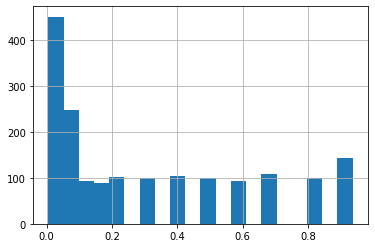

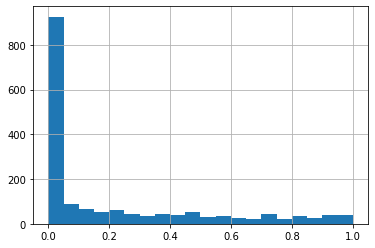

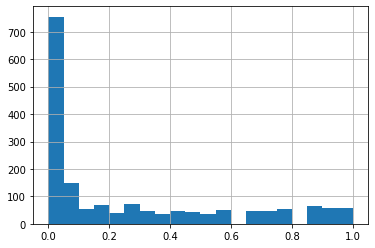

In [123]:
mwr['n'].hist(bins=20)
plt.figure()
mwr['i'].hist(bins=20)
plt.figure()
mwr['d'].hist(bins=20)

<AxesSubplot:>

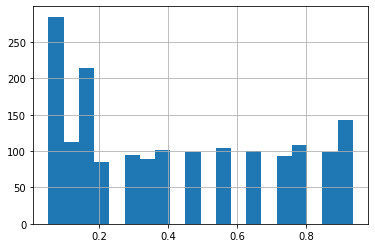

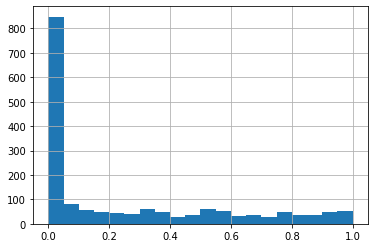

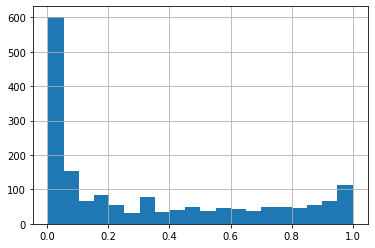

In [124]:
mwr['n_fdr'].hist(bins=20)
plt.figure()
mwr['i_fdr'].hist(bins=20)
plt.figure()
mwr['d_fdr'].hist(bins=20)

In [128]:
mwr.sort_values('d_fdr', ascending=False)

,n,i,d,n_fdr,i_fdr,d_fdr
m_485,0.688921,0.067996,1.000000,0.801189,0.121814,1.000000
l_475,0.936186,0.868226,1.000000,0.936186,0.909294,1.000000
l_198,0.575174,0.900971,1.000000,0.721369,0.930052,1.000000
l_127,0.810181,0.319506,1.000000,0.883323,0.438622,1.000000
l_69,0.575174,0.480731,1.000000,0.721369,0.588810,1.000000
...,...,...,...,...,...,...
m_257,0.030639,0.000011,0.000412,0.133283,0.000073,0.003312
m_197,0.005075,0.000009,0.000412,0.053441,0.000066,0.003312
l_282,0.065552,0.000006,0.000412,0.184981,0.000054,0.003312
m_410,0.065552,0.000003,0.000412,0.184981,0.000054,0.003312
